In [1]:
import os
os.chdir(r"C:\Users\ashto\DAPPEr-main") #change directory to dapper-main folder
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")
import numpy as np
import matplotlib.pyplot as plt
from src import *
from src.UDIP_Lib import *
import src.fitting.fit as Josh_fit
import src.fitting.RockSat_1_14_fitting_functions as R_fit
import src.UDIP_Lib.UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
from src.RockSat_json.RockSat_json import import_data
import numpy as np
from scipy import signal
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

Current directory: C:\Users\ashto\DAPPEr-main


In [2]:
# using these functions outputs as initial guess for Josh's fit functions

def gen_fit(x_raw,y_raw):
    x,y = data_processing(x_raw,y_raw)
    g = [2, 2, 2, -14, 80, 5*(10**10), 700 ]    #intial guess
    b = [
        (-3,  -3, 2, -np.inf, -np.inf, 0     , 0    ),
        ( 3,   3, 5, np.inf,  np.inf, np.inf, 5000 )
        ] #bounds
    popt, pcov = optimize.curve_fit(model,x,y,g,bounds=b)
    max_1 = np.max(x)
    min_1 = np.min(x)
    t = np.linspace(min_1,max_1,num=1000)
    return t, model(t,*popt),popt,pcov #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0]

def model(V, Vf, V0, VP,  b, m1, ne, te):
    I = np.zeros(len(V))
    I[V <= Vf] = lin(V[V <= Vf], m1) - lin(Vf, m1) + b
    Vtrans = (V > Vf) & (V < VP)
    I[Vtrans] = exp(V[Vtrans], ne, te, VP) + b
    I[V >  VP] = sqrt(V[V >  VP], ne, te, V0) - sqrt(VP, ne, te, V0) + b
    return I

def lin(x, m):#linear--full model square root
    return m * x

def exp(x, ne, te, V1):
    q_e = 1.602e-19  # Electron charge [C]
    K_b = 1.381e-23  # Boltzmann constant [J/K]
    m_e = 9.109e-31  # Electron mass [kg]
    R = (3.0 / 16.0) * 2.54  # Radius of probe [cm]
    L = 3.25 * 2.54  # Length of probe [cm]
    A = 2.0 * np.pi * R * L + np.pi * (R ** 2)  # Surface area [cm^2]
    I0 = ne * q_e * np.sqrt(K_b * te/ (2.0 * np.pi * m_e)) * A * 1e-9  # [nA]
    k = q_e / (K_b * te)
    return I0 * np.exp(k * (x - V1))

def sqrt(x,n,t,V0):# square root
    q_e = 1.602 * 10**-19 #C                charge of an electron
    K_b = 1.381 * 10**-23 #m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10**-31 #kg               mass of an electron
    R = (3./16.) * 0.0254 #radius of probe
    L = (3.25) * 0.0254 #length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 =n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1.0 + k*(x - V0))

def data_processing(x_raw,y_raw):#remove data points below -2 and above the peak to reduce datapoints going to the fitting routine
    x = np.nan_to_num(x_raw, nan=0.0)
    y = np.nan_to_num(y_raw, nan=0.0)
    x = x[6:]
    y = y[6:]
    return x,y

In [3]:
def updated_model(V, V0, VP, y_int, m1, ne, Te):
    I = np.zeros(len(V))
    I[V <= VP] = Josh_fit.lin(V[V <= VP], m1, y_int) - Josh_fit.lin(VP, m1, y_int)
    I[V >  VP] = Josh_fit.sqrt(V[V >  VP], ne, Te, V0) - Josh_fit.sqrt(VP, ne, Te, V0) + y_int
    return I

# make the guess an input, which is the output of rocksat:
def updated_gen_fit(V_arr, I_arr, proc=False, g=None):
    if proc:
        V_proc, I_proc = Josh_fit.data_processing(V_arr, I_arr)
    else:
        V_proc, I_proc = V_arr, I_arr

    if g is None:
        g = [2, 2, 80, 10, 5*(10**10), 1500]
        
    b = [
        (-3, 2, -1000, -1000, 5*(10**1), 300),
        ( 3, 5,  1000,  1000, 5*(10**15), 5000)
    ]
    popt, pcov = curve_fit(updated_model, V_proc, I_proc, p0=g, bounds=b)
    V_fit = np.linspace(min(V_proc), max(V_proc), num=300)
    return V_fit, updated_model(V_fit, *popt), popt, pcov


In [4]:
packets = import_data('data/packets/UDIP_4_800s.json')
ne = np.array([])
Te = np.array([])
Imax = np.array([])
t_lin = np.array([])
starting_sweep = 173
stopping_sweep = 450 #170-475 are where we get good data roughly ... sweep 297 doesnt want to make a fit
st = packets['packets']['Full'][f'{starting_sweep}']['Start']
fin = packets['packets']['Full'][f'{stopping_sweep}']['Start']
step   = 1
for sweep in range(starting_sweep, stopping_sweep, step):
#get sweep data
    c = 6
    V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'][c:])
    I = -np.array(packets['packets']['Full'][f'{sweep}']['Current0'][c:]) * 1e9
    midpoint = len(V) // 2
    Vfit1, Ifit1, popt1, pcov1 = gen_fit(V, I) # Rocksat gen fit... use as initial guess

#time data
    start = packets['packets']['Full'][f'{sweep}']['Start']
    stop  = packets['packets']['Full'][f'{sweep}']['Stop']
    t_lin = np.append(t_lin, (start + stop)/2/1000 - 57)
    
#Getting fit data
    #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0] ------> R_fit

    #print("First fit iteration temp:", popt1[4])
    new_initial_guess = [popt1[1], popt1[2], popt1[3], popt1[4], popt1[5], popt1[6]]  # UPDATE THE INDICES BASED ON FITTING ALGORITHM
    # Josh function takes in (V0, VP, m1, y_int, ne, Te), and the popt output from Rocksat is in different order,
# need bounds to avoid it failing
    lower_bounds = np.array([-3, 2, -1000, -1000, 5e1, 300])
    upper_bounds = np.array([3, 5, 1000, 1000, 5e15, 5000])
    new_initial_guess = np.clip(new_initial_guess, lower_bounds, upper_bounds) 
#anything lower or greater than the bounds will just be set to those bound values
    
#Useing rocksat fit function output as initial guess for Josh fit   
    #print(sweep)
    V_fit2, model2, popt2, pcov2 = updated_gen_fit(V, I, g=new_initial_guess)
    ne = np.append(ne, popt2[4])
    Te = np.append(Te, popt2[5])
    #print("Second fit iteration temp:", popt2[5])


# if temp value is bad (>2000), check the top part of branch
    if Te[-1] >= 2000:
        FirstFitTe = Te[-1]
        midpoint = len(V) // 2
        V_new = V[midpoint:]
        I_new = I[midpoint:]
        Vfit1, Ifit1, popt1, pcov1 = gen_fit(V_new, I_new)
        new_initial_guess = [popt1[1], popt1[2], popt1[3], popt1[4], popt1[5], popt1[6]]
        new_initial_guess = np.clip(new_initial_guess, lower_bounds, upper_bounds)
        V_fit2, model2, popt2, pcov2 = updated_gen_fit(V_new, I_new, g=new_initial_guess)
        Te[-1] = popt2[5]
        if Te[-1] >= 2000:
            print(f"Warning: Sweep {sweep} still has Te >= 2000 (Te = {Te[-1]}) after second fit, went from {FirstFitTe} -> {Te[-1]}")
            #maybe i should implement if this new temp is even worse than the original worse value to set it back to the original?
        ne[-1] = popt2[4]
    
    Imax = np.append(Imax, np.max(I))



C:\Users\ashto\AppData\Local\Temp\ipykernel_23596\2632301962.py:48: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1.0 + k*(x - V0))
C:\Users\ashto\DAPPEr-main\src\fitting\fit.py:117: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1. + k*(x - V0))


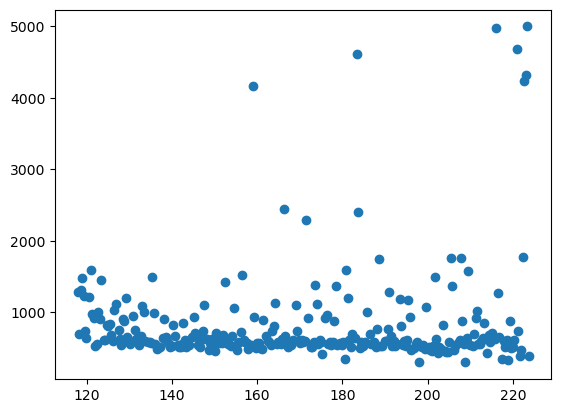

In [5]:
plt.scatter(t_lin,Te)

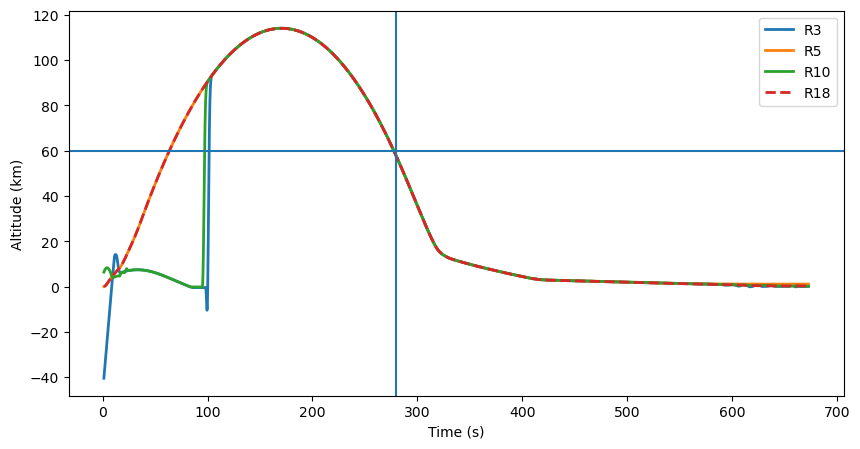

In [6]:
times3 = []
times5 = []
times10 = []
times18 = []
altitudes3 = []
altitudes5 = []
altitudes10 = []
altitudes18 = []
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R5 POSDAT 06202024.txt", "r") as rockonData5: #R5
    next(rockonData5)  # Skip the header
    for line in rockonData5:
        parts = line.strip().split()
        times5.append(float(parts[1]))  # time values
        altitudes5.append(float(parts[9]) / 1000)  # altitude values in km
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R3 POSDAT 06202024.txt", "r") as rockonData3: #R3
    next(rockonData3)  # Skip the header
    for line in rockonData3:
        parts = line.strip().split()
        times3.append(float(parts[1]))  # time values
        altitudes3.append(float(parts[9]) / 1000)  # altitude values in km
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R10 POSDAT 06202024.txt", "r") as rockonData10: #R10
    next(rockonData10)  # Skip the header
    for line in rockonData10:
        parts = line.strip().split()
        times10.append(float(parts[1]))  # time values
        altitudes10.append(float(parts[9]) / 1000)  # altitude values in km
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R18 POSDAT 06202024.txt", "r") as rockonData18:
    next(rockonData18)  # Skip the header
    for line in rockonData18:
        parts = line.strip().split()
        times18.append(float(parts[1]))  # time values
        altitudes18.append(float(parts[9]) / 1000)  # altitude values in km
apogee3 = max(altitudes3)
apogee5 = max(altitudes5)
apogee10 = max(altitudes10)
apogee18 = max(altitudes18)
plt.figure(figsize=(10, 5))
plt.plot(times3, altitudes3, label= "R3", lw=2)
plt.plot(times5, altitudes5, label= "R5",lw=2) #i am using these values for data analysis
plt.plot(times10, altitudes10, label= "R10",lw=2)
plt.plot(times18, altitudes18, label= "R18",lw=2, ls='--')
plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")
plt.legend()
plt.axvline(280)
plt.axhline(60)
plt.show()
#looks like R3,R10 messed up until t=100s, then they all make the same shape, 
# R5 and R18 look very similar, I am arbitrarily using R5 for analysis

In [7]:
altitude_function = interp1d(times5, altitudes5) 
interpolated_altitudes = altitude_function(t_lin) # Make altitude array based on time values from IV data


apogee_value = np.where(interpolated_altitudes == apogee5)[0][0] #cutting list at apogee to find temperatures going up


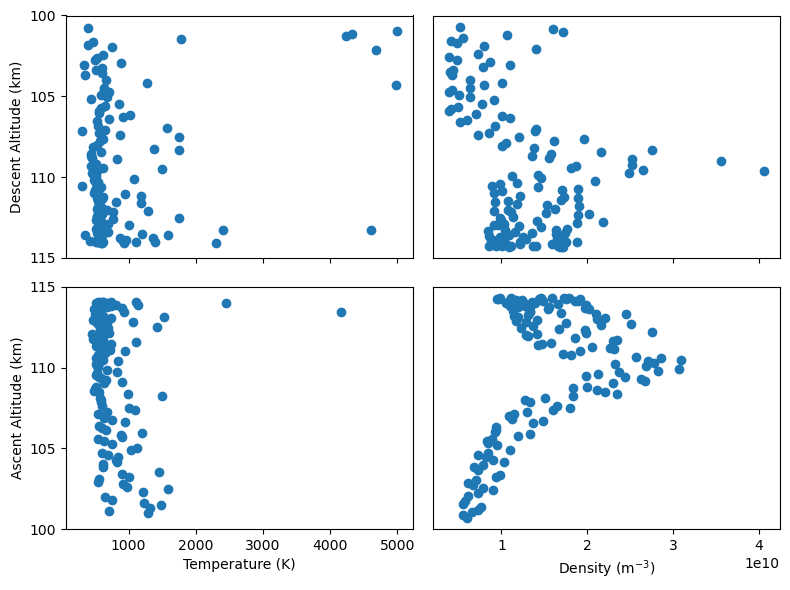

In [8]:
from matplotlib.ticker import MultipleLocator

fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', figsize=(8, 6))

#left side is temperature
axes[1, 0].scatter(Te[:apogee_value], interpolated_altitudes[:apogee_value], label='Ascending') #[1,0] is bottom left
axes[0, 0].scatter(Te[apogee_value + 1:], interpolated_altitudes[apogee_value + 1:], label='Descending') #[0,0] top left

axes[1, 0].set_xlabel('Temperature (K)')
axes[1, 0].set_ylabel('Ascent Altitude (km)')
axes[0, 0].set_ylabel('Descent Altitude (km)')

#right density
axes[1, 1].scatter(ne[:apogee_value], interpolated_altitudes[:apogee_value], label='Ascending') #[1,1] bottom right
axes[0, 1].scatter(ne[apogee_value + 1:], interpolated_altitudes[apogee_value + 1:], label='Descending')#[0,1] top right

axes[1, 1].set_xlabel(r'Density (m$^{-3})$')

for ax in [axes[0, 1], axes[1, 1]]: #Remove y-axis labels and ticks from right-side plots
    ax.set_ylabel("")  
    ax.yaxis.set_tick_params(left=False, labelleft=False)

#tickmarks every 5 km to make it look neater
y_min, y_max = 100, 115
for ax in [axes[0, 0], axes[1, 0]]:
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(MultipleLocator(5)) #tickmark every 5

axes[0, 0].invert_yaxis()
axes[0, 1].invert_yaxis()
#axes[0, 0].set_xlim(0, 2000)
#axes[1, 0].set_xlim(0, 2000)
plt.tight_layout()
plt.show()


# Using only upward sweeps (second half/top branch)

In [9]:
packets = import_data('data/packets/UDIP_4_800s.json')
ne = np.array([])
Te = np.array([])
Imax = np.array([])
t_lin = np.array([])
starting_sweep = 173
stopping_sweep = 450
step = 1

for sweep in range(starting_sweep, stopping_sweep, step):
    try:
        # Get sweep data
        c = 6
        V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'][c:])
        I = -np.array(packets['packets']['Full'][f'{sweep}']['Current0'][c:]) * 1e9
        midpoint = len(V) // 2

        Vfit1, Ifit1, popt1, pcov1 = gen_fit(V[midpoint:], I[midpoint:])

        # Get initial guess
        new_initial_guess = [popt1[1], popt1[2], popt1[3], popt1[4], popt1[5], popt1[6]]
        lower_bounds = np.array([-3, 2, -1000, -1000, 5e1, 300])
        upper_bounds = np.array([3, 5, 1000, 1000, 5e15, 5000])
        new_initial_guess = np.clip(new_initial_guess, lower_bounds, upper_bounds)

        # Second fit
        V_fit2, model2, popt2, pcov2 = updated_gen_fit(V[midpoint:], I[midpoint:], g=new_initial_guess)

        # Only append if everything worked
        ne = np.append(ne, popt2[4])
        Te = np.append(Te, popt2[5])
        Imax = np.append(Imax, np.max(I))

        start = packets['packets']['Full'][f'{sweep}']['Start']
        stop = packets['packets']['Full'][f'{sweep}']['Stop']
        t_lin = np.append(t_lin, (start + stop) / 2 / 1000 - 57)

    except Exception as e:
        print(f"Sweep {sweep} failed to fit: {e}")
        continue


C:\Users\ashto\AppData\Local\Temp\ipykernel_23596\2632301962.py:48: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1.0 + k*(x - V0))


Sweep 297 failed to fit: array must not contain infs or NaNs
Sweep 334 failed to fit: array must not contain infs or NaNs
Sweep 354 failed to fit: array must not contain infs or NaNs
Sweep 366 failed to fit: array must not contain infs or NaNs
Sweep 433 failed to fit: array must not contain infs or NaNs


Looking at IV for bad values

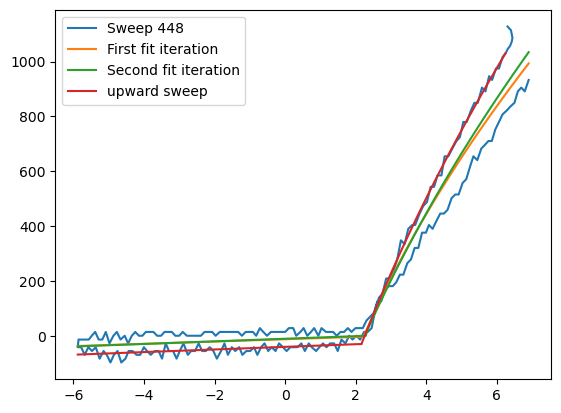

In [34]:
vv = np.array(packets['packets']['Full']['448']['Voltage'][c:])
ii = -np.array(packets['packets']['Full']['448']['Current0'][c:]) * 1e9
Vfitt, Ifitt, poptt, pcovv = gen_fit(vv, ii) # Rocksat gen fit... use as initial guess
initialG = [poptt[1], poptt[2], poptt[3], poptt[4], poptt[5], poptt[6]]  # UPDATE THE INDICES BASED ON FITTING ALGORITHM
    # Josh function takes in (V0, VP, m1, y_int, ne, Te), and the popt output from Rocksat is in different order,
# need bounds to avoid it failing
lower_bounds = np.array([-3, 2, -1000, -1000, 5e1, 300])
upper_bounds = np.array([3, 5, 1000, 1000, 5e15, 5000])
newG = np.clip(initialG, lower_bounds, upper_bounds) 
#anything lower or greater than the bounds will just be set to those bound values
    
#Useing rocksat fit function output as initial guess for Josh fit   
    #print(sweep)
V_fitt2, modell2, poptt2, pcovv2 = updated_gen_fit(vv, ii, g=newG)
plt.plot(vv,ii, label="Sweep 448")
plt.plot(Vfitt,Ifitt, label="First fit iteration")
plt.plot(V_fitt2, modell2, label="Second fit iteration")

VfitTOP, IfitTOP, poptTOP, pcovTOP = gen_fit(vv[:midpoint], ii[:midpoint])
plt.plot(VfitTOP, IfitTOP, label="upward sweep")

plt.legend()

In [11]:
altitude_function = interp1d(times5, altitudes5) 
interpolated_altitudes = altitude_function(t_lin) # Make altitude array based on time values from IV data


apogee_value = np.where(interpolated_altitudes == apogee5)[0][0] #cutting list at apogee to find temperatures going up


ascent

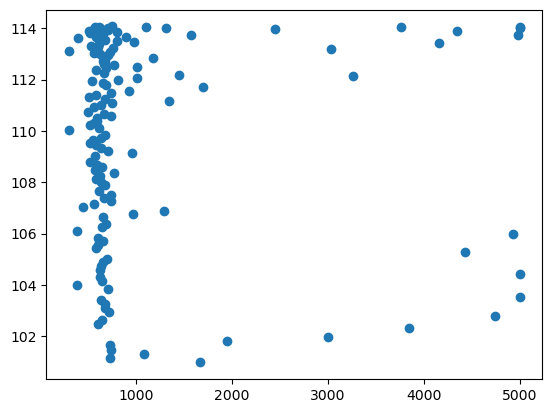

In [12]:
plt.scatter(Te[:136], interpolated_altitudes[:136])

descent

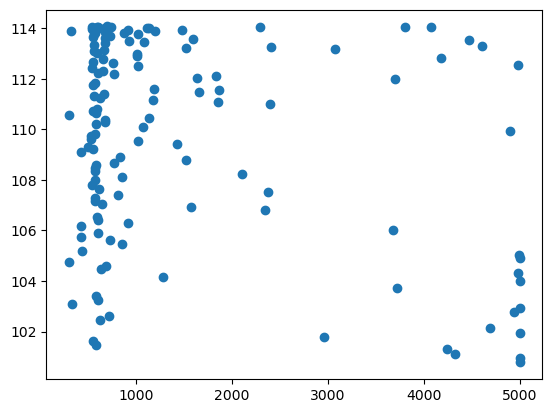

In [13]:
plt.scatter(Te[136:], interpolated_altitudes[136:])